<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/LSTM%E5%9F%BA%E6%9C%AC%E6%B0%97%E6%B8%A9%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM　基本的な方法。　

長・短期記憶(Long short-term memory)と呼ばれます。

深層学習（ディープラーニング）の分野において用いられる再帰型ニューラルネットワーク（RNN）の1種です。

LSTMは、従来のRNNでは難しかった、より昔のデータまでを考慮した学習が可能です。

<img src="./images/LSTM.jpg" width="80%" style="position:relative;left:-10%;">

引用：https://qiita.com/t_Signull/items/21b82be280b46f467d1b

[動画はこちら](https://www.youtube.com/watch?v=4607KV4FGTs&t=0s)

LSTNもRNNも一つ前の情報を参照するという点は同じだけど、アルゴリズムが異なる。

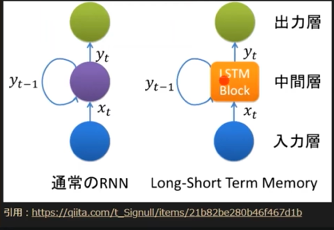

In [2]:
# ライブラリの読み込みと各種設定
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

## データの読み込み

今回使用するデータは、気温の時系列データです。

データ配布元：http://www.data.jma.go.jp/gmd/risk/obsdl/index.php

**まずは、理解を容易にするため、気温データのみを用います**

In [3]:
weather_df = pd.read_csv("/content/weather (1).csv", index_col='年月日', encoding="shift-jis")
#データ読み込みで年月日をindexに格納。

In [ ]:
weather_df

,平均気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),平均現地気圧(hPa)
年月日,,,,,
2015/1/1,3.7,0.0,4.4,1.3,1000.4
2015/1/2,2.7,0.0,2.1,6.0,1007.4
2015/1/3,3.8,0.0,3.0,8.9,1012.0
2015/1/4,4.0,0.0,1.3,6.0,1010.4
2015/1/5,6.9,0.0,2.4,8.9,1014.6
...,...,...,...,...,...
2019/12/28,6.8,0.0,3.5,8.8,1019.9
2019/12/29,7.0,0.0,1.9,8.3,1026.5
2019/12/30,6.7,0.5,1.8,0.0,1021.0


## データの作成

説明変数と目的変数を作っていきます。

説明変数は、時刻(t-p) ~ 時刻(t-1)までの範囲

＊p:単位時間×任意の長さ→どこまで昔のデータを使用したいか

目的変数は、時刻(t)での値

時刻時刻(t-p) から時刻(t-1)までの気温のデータを用いて、時刻ｔの値を予測するというもの。

In [5]:
# 説明変数を格納
data_X = []
# 目的変数を格納
data_y = []
# 時数（どこまで過去のデータを考慮したいか）p = 10　10日まで迄のデータを用いたい。
p = 10
for i in range(len(weather_df)-p):
    data_X.append(weather_df['平均気温(℃)'][i:i+p])
    data_y.append(weather_df['平均気温(℃)'][i+p])
    
data_X = np.array(data_X)
data_y = np.array(data_y)

In [8]:
from sklearn.model_selection import train_test_split
x_train , x_test,y_train,y_test = train_test_split(data_X,data_y, shuffle=False,test_size=0.3)
print(len(x_train),len(x_test))

1271 546


正規化：RNNやLSTNにて必ず必要な処理の事。

In [11]:
# 正規化（Normarization）
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
x_train_n = scaler_x.fit_transform(x_train)
x_test_n = scaler_x.transform(x_test) 
scaler_y = MinMaxScaler() # これは正規化されたものを復元する時にも必要。

y_train_n = scaler_y.fit_transform(y_train.reshape(len(y_train),1))
y_test_n = scaler_y.transform(y_test.reshape(len(y_test),1)) 

In [12]:
# 現在のデータ形式 ⇒どこまで過去を遡ってみるのか。
print(x_train.shape,x_test.shape)

(1271, 10) (546, 10)


## データ形式の変更

上記で見た通り、（データ数, 説明変数の数）の形式になっていますが、

これを、（データ数, 系列数, 説明変数の数）に変更してやる必要があります。

＊系列数：扱う時系列データの種類数

今回は、「気温」だけ扱うので、系列数＝1で大丈夫ですが、「気温」「湿度」など複数の時系列データを扱う際は、その数に応じた数値を指定してやる必要があります。

In [14]:
#1271 1 10が格納されます。という事。
X_train_n = np.reshape(x_train_n, (x_train_n.shape[0], 1, x_train_n.shape[1]))
X_test_n = np.reshape(x_test_n, (x_test_n.shape[0], 1, x_test_n.shape[1]))
# 正規化の実行が完了。

## モデルの実装

データの準備が整いましたので、モデルを「作成→学習→予測」していきます

In [16]:
from keras.layers import LSTM,Dense
from keras import models

モデルの定義

In [17]:
# 時数（どこまで過去のデータを考慮したいか）
p = 10

# モデル定義
model = models.Sequential()
model.add(
    LSTM(
        100, 
        activation='tanh', #活性化関数tan
        input_shape=(1, p)
    )
)
model.add(Dense(1,activation='linear'))#出力数のユニット数が１。高等化関数は１

# 学習設定
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [18]:
# モデルの学習
result = model.fit(
    X_train_n, 
    y_train_n, 
    batch_size=10, 
    epochs=100
)

Epoch 1/100
128/128 [==============================] - 3s 3ms/step - loss: 0.0269
Epoch 2/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0056
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 7/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 8/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 9/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 10/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 11/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 12/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 13/100


In [21]:
# 予測値の算出
y_prediction_n = model.predict(X_test_n)
# 正規化の復元。ここでスカラーｙを用いて正規化の復元を行う。
y_prediction = scaler_y.inverse_transform(y_prediction_n).flatten()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_te

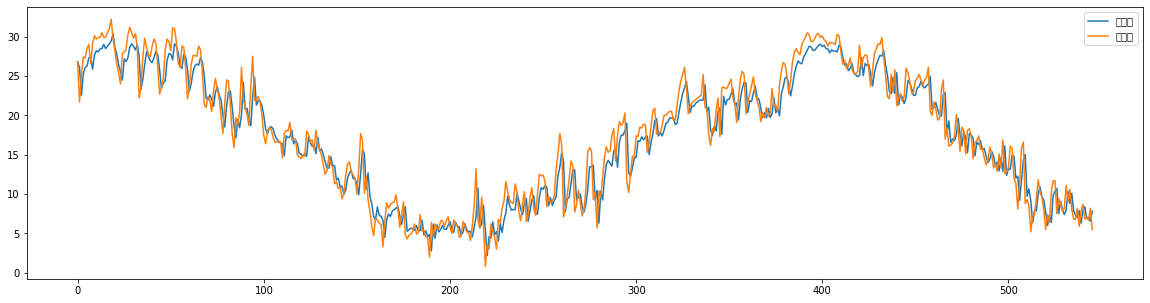

In [22]:
plt.plot(y_prediction, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

In [23]:
# 乖離度
print(
    np.mean(
        np.abs(y_prediction-y_test)
        /y_test
    )
)

0.13247028504212713


# 複雑なモデルの実装

前述のモデルは、過去の「気温」のみのデータを用いて、未来の「気温」を予測しましたが、

次は、過去の<font color="red">「気温」「日照時間」</font>のデータを用いて、未来の「気温」を予測してみます。

## データの作成

In [24]:
# 正規化（Normarization）
from sklearn.preprocessing import MinMaxScaler
scaler_x1 = MinMaxScaler()
x1 = scaler_x1.fit_transform(weather_df['平均気温(℃)'].values.reshape(weather_df['平均気温(℃)'].shape[0],1))
scaler_x2 = MinMaxScaler()
x2 = scaler_x2.fit_transform(weather_df['日照時間(時間)'].values.reshape(weather_df['日照時間(時間)'].shape[0],1))

In [25]:
# 説明変数を格納
data_X = []
# 目的変数を格納
data_y = []
# 時数（どこまで過去のデータを考慮したいか）
p = 10
for i in range(len(weather_df)-p):
    data_X.append([x1[i:i+p].flatten(),x2[i:i+p].flatten()])
    data_y.append(x1[i+p])
    
data_X = np.array(data_X)
data_y = np.array(data_y)

In [26]:
# 訓練データとテストデータに分けます。
len_train = int(len(data_X)*0.7)

X_train = data_X[:len_train]
X_test = data_X[len_train:]
y_train = data_y[:len_train]
y_test = data_y[len_train:]

print(len(X_train),len(X_test))

1271 546


気温と日照時間を用いるのでinput=2にする。

In [27]:
# 時数（どこまで過去のデータを考慮したいか）
p = 10

# モデル定義
model = models.Sequential()
model.add(
    LSTM(
        100, 
        activation='tanh', 
        input_shape=(2, p)
    )
)
model.add(Dense(1,activation='linear'))

# 学習設定
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
)

In [28]:
# モデルの学習
result = model.fit(
    X_train, 
    y_train, 
    batch_size=10, 
    epochs=100
)

Epoch 1/100
128/128 [==============================] - 2s 3ms/step - loss: 0.0260
Epoch 2/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 4/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 5/100
128/128 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 6/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 7/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 8/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 9/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 10/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 11/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 12/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 13/100


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_te

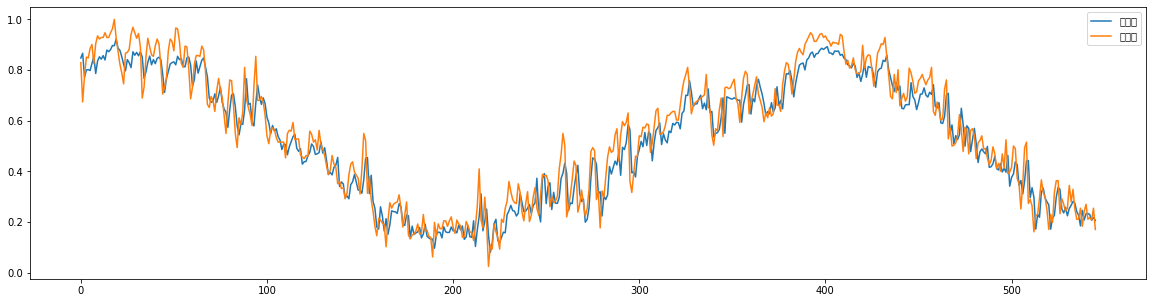

In [29]:
# 予測
y_prediction = model.predict(X_test).flatten()

plt.plot(y_prediction, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

In [30]:
# 乖離度
print(
    np.mean(
        np.abs(y_prediction-y_test.flatten())
        /y_test
    )
)

0.1384795219304244
